# Plotting raw tree
#### Se forklaringer (source)
http://www.science.smith.edu/~jcrouser/SDS293/labs/2016/lab14/Lab%2014%20-%20Decision%20Trees%20in%20Python.pdf
https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
https://www.youtube.com/watch?v=D0efHEJsfHo&list=PLblh5JKOoLUICTaGLRoHQDuF_7q2GfuJF&index=37

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

from sklearn import model_selection
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error


df = pd.read_csv('carseats.csv')
display(df.head(3))

# Create 'High' column with 1=sales>8 and 0=sales<8
df['High'] = df.Sales.map(lambda x: 1 if x>8 else 0)
# factorize bad/good/medium = a number representation based on ??
df.ShelveLoc = pd.factorize(df.ShelveLoc)[0]
# Set yes/no to 1/0
df.Urban = df.Urban.map({'No':0, 'Yes':1})
df.US = df.US.map({'No':0, 'Yes':1})
df.head(10)

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes


,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0
5,10.81,124,113,13,501,72,0,78,16,0,1,1
6,6.63,115,105,0,45,108,2,71,15,1,0,0
7,11.85,136,81,15,425,120,1,67,10,1,1,1
8,6.54,132,110,0,108,124,2,76,10,0,0,0
9,4.69,132,113,0,131,124,2,76,17,0,1,0


Numbers of features in X: 10
Currant tree: Dept: 2   Score: 0.69

With dept: 11  Score: 1.00 = overfitting


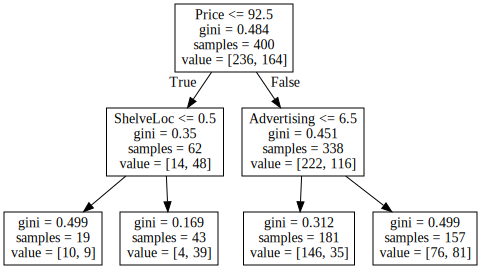

In [2]:
# Set X = df without Sales and Heigh
X = df.drop(['Sales', 'High'], axis=1)
n_features = len(X.columns);
print("Numbers of features in X:",n_features)
# Set y = High
y = df.High

# Fitting train data
maxDepth = 2
clf = DecisionTreeClassifier(max_depth=maxDepth)
clf.fit(X, y)
score = clf.score(X, y)
# ugly print
#tree.plot_tree(clf.fit(X, y), feature_names=X.columns)
print("Currant tree: Dept:",maxDepth,"  Score:",score)
print("\nWith dept: 11  Score: 1.00 = overfitting")

# nice print
export_graphviz(clf, out_file="mytree.dot", feature_names=X.columns)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [3]:
# Shows correct predictions VS the actual y
pred = clf.predict(X)
cm = pd.DataFrame(confusion_matrix(y, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
print(cm)

      No  Yes
No   156   44
Yes   80  120


# Test data for CV

In [9]:
# Split into training and test sets
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.5, random_state=1)

# Fitting train data (full tree)
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(score)

0.78


In [5]:
# 10-fold CV, with shuffle
kf_10 = model_selection.KFold( n_splits=10, shuffle=True, random_state=1 )
# Array to store mse values
mse = []
n = len(X_train)

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*model_selection.cross_val_score(clf, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the n_features principle components, adding one component at the time.
for i in np.arange(1, n_features):
    score = -1*model_selection.cross_val_score(clf, X_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1);

pcaMinMSE = np.where(mse == np.amin(mse))
pcaMinMSE = int(pcaMinMSE[0])
print(pcaMinMSE)

TypeError: '(slice(None, None, None), slice(None, 1, None))' is an invalid key